## TO DO

add augmentations,
Kfold
Different Archs of model


## Party begins

In [1]:
import PIL
from PIL import Image
import numpy as np, pandas as pd
import os
import torch
import torchvision
import tensorflow as tf
import keras.backend as K
from fastai.vision.all import *
import matplotlib.pyplot as plt
import cv2
import albumentations as A


## Visualise Data

In [2]:
TRAINDIR='../input/histopathologic-cancer-detection/train'
TESTDIR='../input/histopathologic-cancer-detection/test'
SUB_CSV='../input/histopathologic-cancer-detection/sample_submission.csv'
TRAIN_CSV='../input/histopathologic-cancer-detection/train_labels.csv'

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.id='../input/histopathologic-cancer-detection/train/'+train_df.id+'.tif'
train_df.head(10)

id  \
0  ../input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif   
1  ../input/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif   
2  ../input/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif   
3  ../input/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif   
4  ../input/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif   
5  ../input/histopathologic-cancer-detection/train/acfe80838488fae3c89bd21ade75be5c34e66be7.tif   
6  ../input/histopathologic-cancer-detection/train/a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif   
7  ../input/histopathologic-cancer-detection/train/7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif   
8  ../input/histopathologic-cancer-detection/train/559e55a64c9ba828f700e948f6886f4cea919261.tif   
9  ../input/histopathologic-cancer-detection/train/8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif   

   label  
0      0  
1      1  
2      0  
3      0  
4      0  
5      0  
6      1  
7      1  
8      0  
9      0

In [4]:
print(len(train_df['id'].unique()))
print("negetive cases: ",len(train_df[train_df['label']==0]))
print("positive cases: ",len(train_df[train_df['label']==1]))

220025
negetive cases:  130908
positive cases:  89117


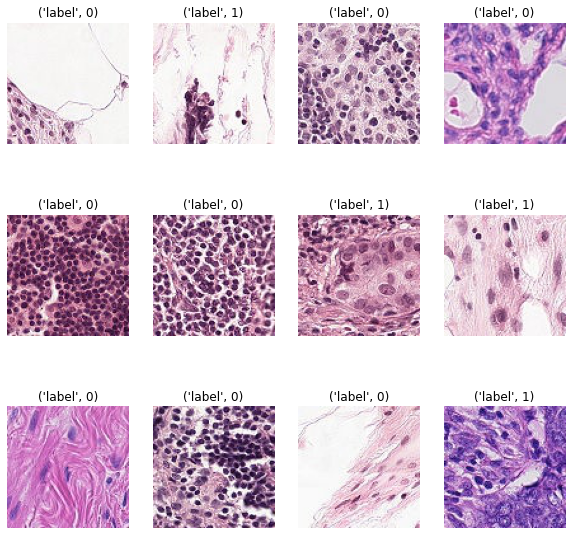

In [5]:
rows,columns=3,4
fig, ax= plt.subplots(rows,columns,figsize=(10,10))
k=0
for i in range(rows):
    for j in range(columns):
        p=cv2.imread(train_df.id[k])
        p=cv2.cvtColor(p, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(p)
        ax[i,j].title.set_text(('label' ,train_df.label[k]))
        ax[i,j].axis('off')
        k+=1

In [6]:
# !pip install -q tensorflow-io
# import tensorflow_io as tfio
# p=tf.io.read_file('../input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')
# p=tfio.experimental.image.decode_tiff(p)
# p.shape

## Pipeline 

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,base_path=TRAINDIR, csv_path=TRAIN_CSV,batch_size=128 ,shuffle=True,width=96,height=96,df=train_df,augmentation=True):
        self.base_path=base_path,
        self.csv_path=csv_path,
        self.df=df
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.width=width
        self.height=height
        self.augmentation=augmentation
        self.on_epoch_end()
        
    def __len__(self):
        ct= int(np.floor(len(self.df)/self.batch_size))
        if len(self.df)>ct*self.batch_size: ct=ct+1
        return ct
    
    def on_epoch_end(self):
        self.indexes=np.arange(int(len(self.df)))
        if self.shuffle: np.random.shuffle(self.indexes)
    def augment(self,img):
        transform = A.Compose([
        A.RandomRotate90(p=0.3),
        A.Flip(p=0.4),
        A.Transpose(p=0.2),
    
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
       
    ])
        return transform(image=img)['image']
    
    def __getitem__(self,index):
        idxs=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        imgs=np.empty((len(idxs),self.width,self.height,3),dtype=np.float)
        labels=np.empty(len(idxs),dtype=np.float)
        for i,ID in enumerate(idxs):
            img_path=self.df['id'][ID] #os.path.join('../input/histopathologic-cancer-detection/train',self.df['id'][ID])
            img=cv2.imread(img_path)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            if self.augmentation:
                img=self.augment(img)
            label=self.df['label'][ID]
            imgs[i]=img
            labels[i]=label
            
        return imgs/255,labels  # deviding the images is very crucial if you want them to be in (0,1) and
                                # also when plotting, If you don't want to devide by 255,  convert the dtype to np.uint8
                                # that will atleat help in plotting the batch
            

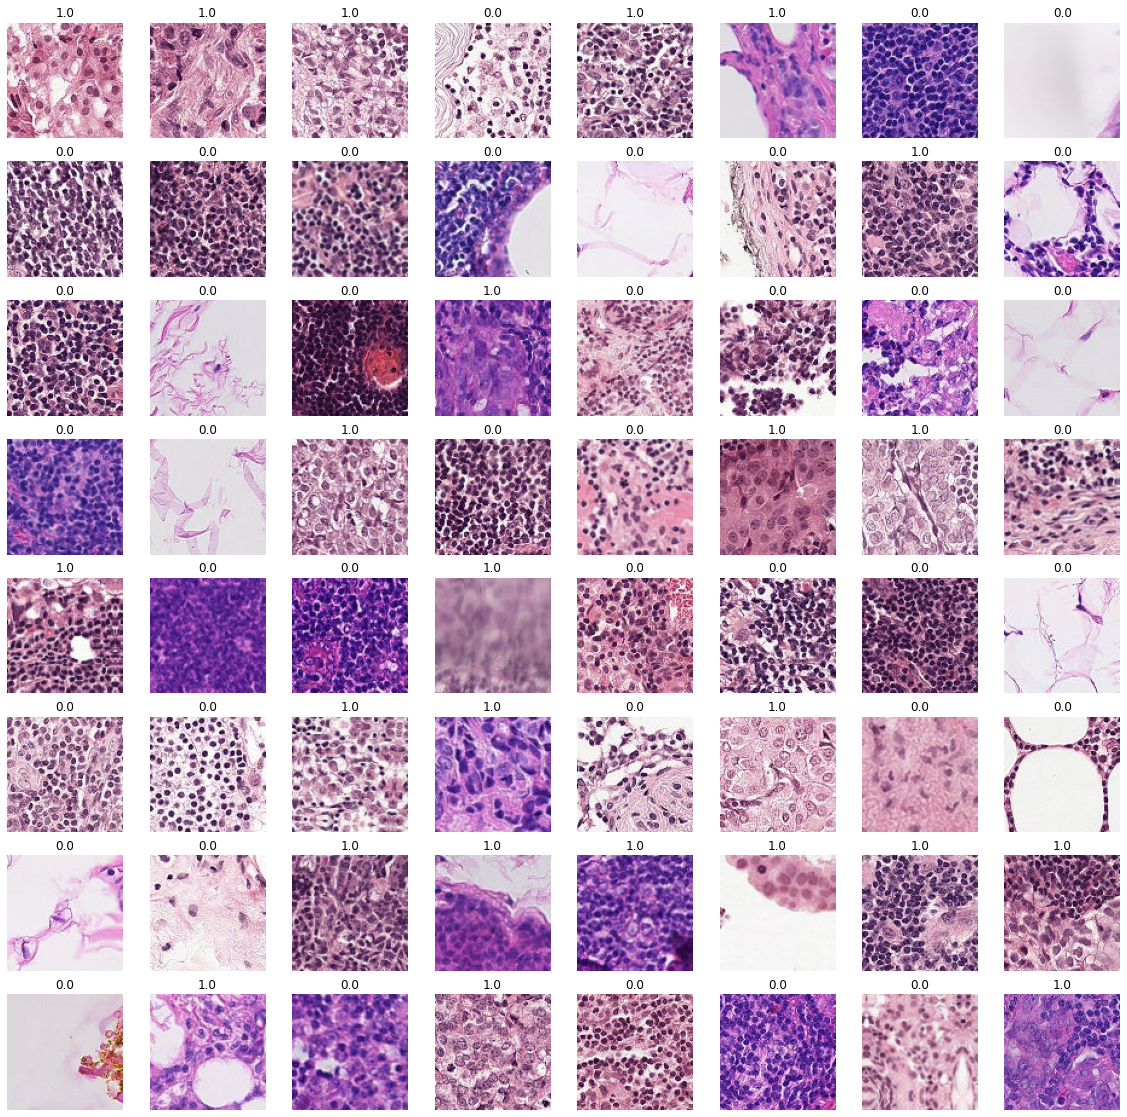

In [8]:
t=DataGenerator()
p,l=t.__getitem__(32)

fig, ax= plt.subplots(8,8,figsize=(20,20))
k=0
for i in  range(8):
    for j in range(8):
        ax[i,j].imshow(p[k])
        ax[i,j].title.set_text(l[k])
        ax[i,j].axis('off')
        k+=1


In [9]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


In [10]:
def build_model():
    
    efficient_net = tf.keras.applications.DenseNet121(classes=2, 
                                                      include_top=False,
                                                      input_shape=(96,96,3))

    inp = tf.keras.Input(shape=(96,96,3))
    x = efficient_net(inp)
    gap = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAvgPool')(x)
    gap=dense_block(1024, 0.4)(gap)
    gap=dense_block(512, 0.4)(gap)
    gap = tf.keras.layers.Dense(2, activation='linear')(gap)

    gmp = tf.keras.layers.GlobalMaxPooling2D(name='GlobalMaxPool')(x)
    gmp=dense_block(1024, 0.4)(gmp)
    gmp=dense_block(512, 0.4)(gmp)
    # gmp=dense_block(64, 0.3)(gmp)

    gmp = tf.keras.layers.Dense(2, activation='linear')(gmp)

    out = tf.keras.layers.add([gap, gmp])
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

In [11]:
model_name='DenseNet121'

In [12]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(5,shuffle=False)
k=0
batch_size=128
for train_id,val_id in skf.split(train_df['id'],train_df['label']):
# train,val=train_test_split(train_df,stratify=train_df['label'],test_size=0.2)
# train_gen=DataGenerator(df=train.reset_index())
# val_gen=DataGenerator(df=val.reset_index())
    k+=1
    print("*"*25)
    print("FOLD ",k)
    train_gen=DataGenerator(df=train_df.iloc[train_id].reset_index(),augmentation=True,batch_size=batch_size)
    val_gen=DataGenerator(df=train_df.iloc[val_id].reset_index(),augmentation=False)

    ERS=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
    LRS=tf.keras.callbacks.ReduceLROnPlateau(verbose=1,patience=3)

    Save=tf.keras.callbacks.ModelCheckpoint(model_name+'_fold_%i.h5'%k,save_weights_only=True,
                                             monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                            save_best_only=True)
    
    model=build_model()

    model.compile( 
         optimizer= 'Adam',
         loss='BinaryCrossentropy',
        metrics = ['accuracy','Precision','AUC','Recall'])


    history=model.fit_generator(train_gen,
                                epochs=30,             
                                steps_per_epoch=len(train_id)//batch_size,
                                validation_data=val_gen,verbose=1,
                                callbacks=[ERS,LRS,Save],
                                workers=10,
                                class_weight={0: 1., 1: len(train_df[train_df['label']==0])/len(train_df[train_df['label']==1])},
                               )
    del model , train_gen , val_gen

*************************
FOLD  1
29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/30
1375/1375 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9136 - precision: 0.8878 - auc: 0.9685 - recall: 0.9007- ETA: 8s - loss: 0.2683 - accuracy: 0.9132 - preci
Epoch 00001: val_loss improved from inf to 0.34263, saving model to DenseNet121_fold_1.h5
1375/1375 [==============================] - 294s 214ms/step - loss: 0.2669 - accuracy: 0.9136 - precision: 0.8878 - auc: 0.9685 - recall: 0.9007 - val_loss: 0.3426 - val_accuracy: 0.8630 - val_precision: 0.9417 - val_auc: 0.9436 - val_recall: 0.7055
Epoch 2/30
1375/1375 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9382 - precision: 0.9194 - auc: 0.9822 - recall: 0.9288
Epoch 00002: val_loss improved from 0.34263 to 0.30278, saving model to DenseNet121_fold_1.h5
1375/1375 [==============================] - 277s 201ms/step - loss: 0.1979 - accuracy: 0.9382 - precision: 0.9194 - 

1375/1375 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9226 - precision: 0.8999 - auc: 0.9734 - recall: 0.9101
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.24697
1375/1375 [==============================] - 267s 194ms/step - loss: 0.2440 - accuracy: 0.9226 - precision: 0.8999 - auc: 0.9734 - recall: 0.9101 - val_loss: 0.8032 - val_accuracy: 0.8145 - val_precision: 0.9880 - val_auc: 0.9558 - val_recall: 0.5486
Epoch 5/30
1375/1375 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9419 - precision: 0.9255 - auc: 0.9834 - recall: 0.9317
Epoch 00005: val_loss improved from 0.24697 to 0.20276, saving model to DenseNet121_fold_2.h5
1375/1375 [==============================] - 268s 195ms/step - loss: 0.1900 - accuracy: 0.9419 - precision: 0.9255 - auc: 0.9834 - recall: 0.9317 - val_loss: 0.2028 - val_accuracy: 0.9505 - val_precision: 0.9530 - val_auc: 0.9864 - val

Epoch 21/30
1375/1375 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9665 - precision: 0.9552 - auc: 0.9936 - recall: 0.9623
Epoch 00021: val_loss improved from 0.08335 to 0.08235, saving model to DenseNet121_fold_2.h5
1375/1375 [==============================] - 269s 196ms/step - loss: 0.1138 - accuracy: 0.9665 - precision: 0.9552 - auc: 0.9936 - recall: 0.9623 - val_loss: 0.0824 - val_accuracy: 0.9712 - val_precision: 0.9629 - val_auc: 0.9951 - val_recall: 0.9661
Epoch 22/30
1375/1375 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9670 - precision: 0.9561 - auc: 0.9936 - recall: 0.9628
Epoch 00022: val_loss did not improve from 0.08235
1375/1375 [==============================] - 267s 194ms/step - loss: 0.1132 - accuracy: 0.9670 - precision: 0.9561 - auc: 0.9936 - recall: 0.9628 - val_loss: 0.0825 - val_accuracy: 0.9714 - val_precision: 0.9637 - val_auc: 0.9951 - val_recall: 0.9658
Epoch 23/30
1375/1375 [==============================

1375/1375 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9799 - precision: 0.9723 - auc: 0.9973 - recall: 0.9782
Epoch 00025: val_loss did not improve from 0.06632
1375/1375 [==============================] - 267s 195ms/step - loss: 0.0701 - accuracy: 0.9799 - precision: 0.9723 - auc: 0.9973 - recall: 0.9782 - val_loss: 1.2826 - val_accuracy: 0.9739 - val_precision: 0.9674 - val_auc: 0.9879 - val_recall: 0.9681
Epoch 26/30
1375/1375 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9806 - precision: 0.9730 - auc: 0.9974 - recall: 0.9792
Epoch 00026: val_loss did not improve from 0.06632
1375/1375 [==============================] - 268s 195ms/step - loss: 0.0678 - accuracy: 0.9806 - precision: 0.9730 - auc: 0.9974 - recall: 0.9792 - val_loss: 1.4636 - val_accuracy: 0.9747 - val_precision: 0.9703 - val_auc: 0.9881 - val_recall: 0.9672
Epoch 00026: early stopping
*************************
FOLD  4
Epoch 1/30
1375/1375 [========================

KeyboardInterrupt: 

## Inference

In [ ]:
model=build_model()
model_fold_1=model.load_weights('./DenseNet121_fold_1.h5')
model_fold_2=model.load_weights('./DenseNet121_fold_2.h5')
model_fold_3=model.load_weights('./DenseNet121_fold_3.h5')
model_fold_4=model.load_weights('./DenseNet121_fold_4.h5')
model_fold_5=model.load_weights('./DenseNet121_fold_5.h5')

In [ ]:
sub_file=pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
sub=sub_file.copy()
sub_file.id='../input/histopathologic-cancer-detection/test/'+sub_file.id+'.tif'
test_gen=DataGenerator(df=sub_file,shuffle=False,batch_size=1,augmentation=False)
k=0
thresh=0.5

for i,batch in enumerate(test_gen):
    
    p=model_fold_1.predict_on_batch(batch)
    p+=model_fold_2.predict_on_batch(batch)
    p+=model_fold_3.predict_on_batch(batch)
    p+=model_fold_4.predict_on_batch(batch)
    p+=model_fold_5.predict_on_batch(batch)
    p/=5
    for i in (p):
        if i >thresh:sub.iloc[k,1]=1
        else : sub.iloc[k,1]=0
        
            
sub_file.label=sub.label
sub.to_csv('sub_histo_cancer.csv',index=Fasle)


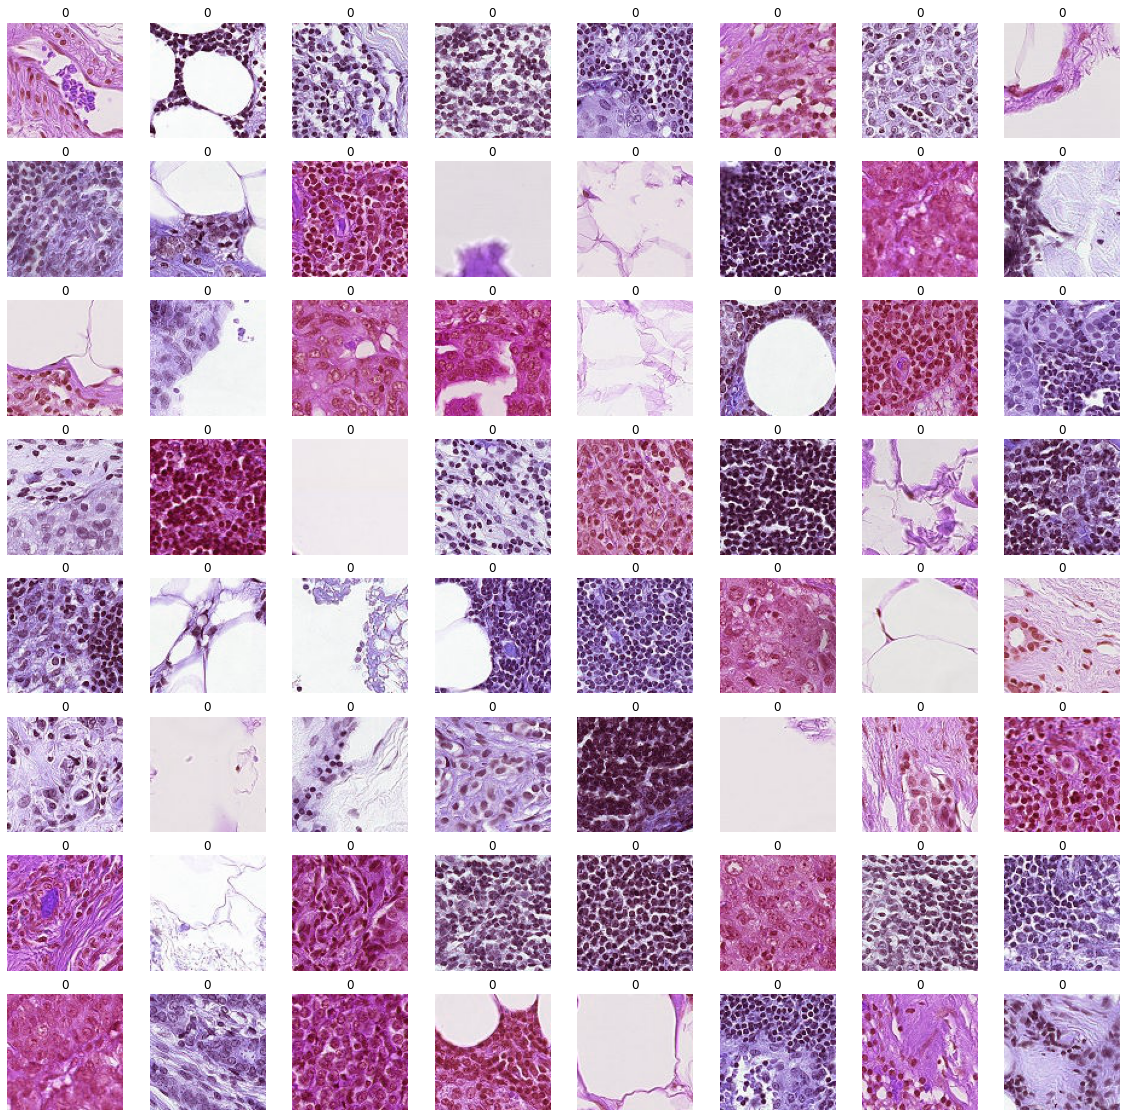

In [20]:
row,col=8,8
_,ax=plt.subplots(row,col,figsize=(20,20))
k=0
for i in range(row):
    for j in range(col):
        k+=1
        ax[i,j].imshow(cv2.imread(sub_file.id[k]))
        ax[i,j].axis("off")
        ax[i,j].title.set_text(sub_file.label[k])
        